<a href="https://colab.research.google.com/github/zawuya/Exploratory-Data-Analysis-/blob/Dlab-Project/telecom_sentiment_3_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Version 3.1

## 1. Import dataset

In [178]:
#import useful libraries
import pandas as pd
import numpy as np
import seaborn as sns
import re 
import joblib
import matplotlib.pyplot as plt
import warnings
import xgboost as xgb
import catboost as ctb
import lightgbm as ltb
from sklearn.metrics import accuracy_score, f1_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay 
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
#from sklearn.xgboost import XGBClassifier
#from sklearn.catboost import CatBoostClassifier
#from sklearn.lightgbm import LGBMClassifier


In [179]:
warnings.filterwarnings("ignore")

In [180]:
telecom_data=pd.read_csv("telecom_TZ_sentiment_data2.csv", dtype=str)

In [181]:
telecom_data.head()

,date,comment,platform,sentiment
0,2021-10-23 14:36:34+00:00,Chezea songesha wew https://t.co/FfnSsIkZGU,Twitter,1
1,2021-09-28 15:37:16+00:00,Tafuta hela sana ili usilalamikie mabadiliko y...,Twitter,1
2,2022-09-18 13:37:06+00:00,Hivi huu mtandao wa Tigo una tatizo au simu ya...,Twitter,-1
3,2021-04-08 18:34:13+00:00,@DaktariWaWatoto Tamtam bando ni ðŸ”¥ ila kuin...,Twitter,1
4,2022-09-24 05:03:32+00:00,@VodacomTanzania @ImranHussein84 Tatizo kifuru...,Twitter,-1


# 2. Exploratory Data Analysis

In [182]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8790 entries, 0 to 8789
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       8789 non-null   object
 1   comment    8789 non-null   object
 2   platform   8788 non-null   object
 3   sentiment  8782 non-null   object
dtypes: object(4)
memory usage: 274.8+ KB


In [194]:
telecom_data.describe()

,date,comment,platform,sentiment
count,8789,8789,8788,8782
unique,8578,8775,3,4
top,2022-01-07 16:34:48+00:00,@airtel_tanzania nawapenda sana huduma hii ya ...,Twitter,-1
freq,2,2,8786,4649


In [195]:
telecom_data.isna().sum()

date         1
comment      1
platform     2
sentiment    8
dtype: int64

In [196]:
telecom_data['sentiment'].value_counts()

-1           4649
0            3567
1             565
complains       1
Name: sentiment, dtype: int64

In [197]:
telecom_data.duplicated().sum()

11

# 3. Data Processing

## 3.1 Remove duplicate

In [198]:
telecom_data.drop_duplicates(subset=['comment'], keep='first', inplace=True)

## 3.2 Remove null values

In [199]:
telecom_data.dropna(subset=['sentiment', 'comment'], inplace=True)

## check the dataset status

In [200]:
telecom_data.duplicated().sum()

0

In [201]:
telecom_data.isna().sum()

date         0
comment      0
platform     0
sentiment    0
dtype: int64

In [44]:
telecom_data.count()

date         8768
comment      8768
platform     8768
sentiment    8768
dtype: int64

<AxesSubplot:xlabel='sentiment', ylabel='count'>

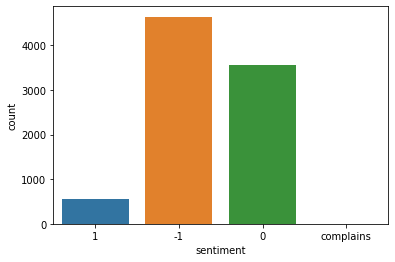

In [202]:
sns.countplot(x="sentiment", data=telecom_data)

In [203]:
telecom_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8768 entries, 0 to 8789
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   date       8768 non-null   object
 1   comment    8768 non-null   object
 2   platform   8768 non-null   object
 3   sentiment  8768 non-null   object
dtypes: object(4)
memory usage: 600.5+ KB


# 3.3 Cleaning

In [204]:
def clean_data_set(list_text):
    new_list = []
    stopwords_df = pd.read_csv("swahili_stopwords.csv", dtype=str, low_memory=False, encoding="utf-8")
    stopwords_list = list(stopwords_df['StopWords'])
    
    for x in list_text:
        x = re.sub(r'@[\w]+','', str(x)) # remove twitter handle
        x = re.sub(r'\w+:\/{2}[\d\w-]+(\.[\d\w-]+)*(?:(?:\/[^\s/]*))*', '', str(x)) # removes Url
        x = re.sub(r'[^\w\s]',' ', str(x))    # Remove Panctuations /?!. 
        x = x.strip()                   # Remove leading and trailing spaces
        x = re.sub(' +', ' ', x)        # Remove extra white spaces
        x = re.sub('[^A-Za-z0-9]+', ' ', x)  # Remove special characters
        x = x.lower()                   # Converts to lower case
        x = ' '.join([word for word in x.split() if word not in stopwords_list]) # Removes stopwords
        new_list.append(x)
    return new_list

In [205]:
telecom_data["clean_comment"] = clean_data_set(telecom_data.comment.to_list())

In [210]:
telecom_data[['comment', 'clean_comment']]

,comment,clean_comment
0,Chezea songesha wew https://t.co/FfnSsIkZGU,chezea songesha wew
1,Tafuta hela sana ili usilalamikie mabadiliko y...,tafuta hela usilalamikie mabadiliko vifurushi ...
2,Hivi huu mtandao wa Tigo una tatizo au simu ya...,mtandao tigo una tatizo simu siku tatu leo mam...
3,@DaktariWaWatoto Tamtam bando ni ðŸ”¥ ila kuin...,tamtam bando kuinunulia mpk tpesa
4,@VodacomTanzania @ImranHussein84 Tatizo kifuru...,tatizo kifurushi internet nw akikai awali una ...
...,...,...
8785,@LuisaUhuru Unastream kutumia mtandao gani\nÃ°...,unastream kutumia mtandao gani
8786,Sasa mnasema mmebadilisha vifurushi naomba mni...,mnasema mmebadilisha vifurushi naomba mnitajie...
8787,@George_Ambangil @Tigo_TZ Sasa kama ad ww unal...,ad ww unalalamika vo mm nan niendelee kutumia ...
8788,@mafolebaraka @Haloteltz Bora wewe mi nikitumi...,bora mi nikitumiwa pesa halopesa haiingii wala...


In [211]:
telecom_data.to_csv("clean_telecom_data.csv", index=False)

# 4 Modeling

In [212]:
clean_telecom_data = pd.read_csv("clean_telecom_data.csv")

In [213]:
telecom_data["clean_comment"]

0                                     chezea songesha wew
1       tafuta hela usilalamikie mabadiliko vifurushi ...
2       mtandao tigo una tatizo simu siku tatu leo mam...
3                       tamtam bando kuinunulia mpk tpesa
4       tatizo kifurushi internet nw akikai awali una ...
                              ...                        
8785                       unastream kutumia mtandao gani
8786    mnasema mmebadilisha vifurushi naomba mnitajie...
8787    ad ww unalalamika vo mm nan niendelee kutumia ...
8788    bora mi nikitumiwa pesa halopesa haiingii wala...
8789    weuh sivyo situation zina chapa but haziru tun...
Name: clean_comment, Length: 8768, dtype: object

In [214]:
# Split datasate into training and test chunks with a ratio of 8:0 respective
X_train, X_test, y_train, y_test = train_test_split(clean_telecom_data["clean_comment"], clean_telecom_data["sentiment"], test_size=0.2, random_state=42, shuffle=True)

In [215]:
print("Training sample size = ", X_train.shape[0])

Training sample size =  7014


In [216]:
print("Testing sample size = ", X_test.shape[0])

Testing sample size =  1754


# 4.1 SUPPORT VECTOR MACHINE (SVM)

In [219]:
# Initialize a vectorization and modelling pipeline
svm_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', SVC(kernel = 'sigmoid', random_state=0, gamma='scale', C=1.2, probability=True)), #tunned svm
 ])

In [220]:
# SVM Algorithm training X_train, X_test, y_train, y_test
svm_model = svm_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
svm_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 SVC(C=1.2, kernel='sigmoid', probability=True,
                     random_state=0))])

In [221]:
y_pred = svm_model.predict(X_test.values.astype('U'))
svm_model.classes_

array(['-1', '0', '1', 'complains'], dtype='<U9')

In [222]:
cm = confusion_matrix(y_test, y_pred, labels=svm_model.classes_)
print(cm)

[[722 226   4   0]
 [294 404   0   0]
 [ 53  51   0   0]
 [  0   0   0   0]]


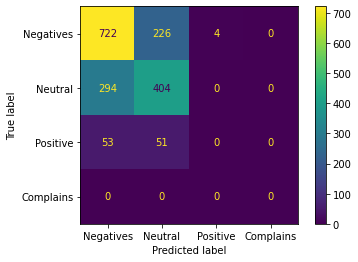

In [223]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [224]:
%%time

#predicting 
y_pred = svm_model.predict(X_test.values.astype('U'))

model_score = svm_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6419612314709237
Model Score: 64.20%

Accuracy: 0.6419612314709237
Accuracy: 64.20%

F1-score: 0.6209705250011016
F1-score: 62.10%

CPU times and Wall time: 
CPU times: user 1.86 s, sys: 5.9 ms, total: 1.87 s
Wall time: 1.88 s


In [225]:
# Save to file / directory
joblib_file = "models/SVM_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(svm_model, joblib_file)

['models/SVM_model_score_64.2.pkl']

## 4.2 RANDOM FOREST

In [226]:
# Initialize a vectorization and modelling pipeline
rf_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', RandomForestClassifier()), #tunned svm
 ])

In [227]:
# RANDOM FOREST Algorithm training X_train, X_test, y_train, y_test
rf_model = rf_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
rf_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', RandomForestClassifier())])

In [228]:
y_pred = rf_model.predict(X_test.values.astype('U'))
rf_model.classes_

array(['-1', '0', '1', 'complains'], dtype='<U9')

In [229]:
cm = confusion_matrix(y_test, y_pred, labels=rf_model.classes_)
print(cm)

[[731 214   1   6]
 [317 375   1   5]
 [ 53  46   4   1]
 [  0   0   0   0]]


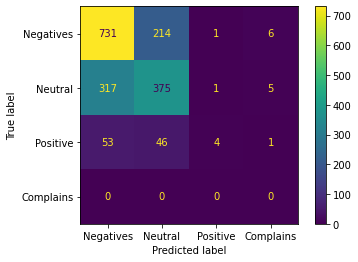

In [230]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [231]:
%%time

#predicting 
y_pred = rf_model.predict(X_test.values.astype('U'))

model_score = rf_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6328392246294184
Model Score: 63.28%

Accuracy: 0.6328392246294184
Accuracy: 63.28%

F1-score: 0.6147281853091169
F1-score: 61.47%

CPU times and Wall time: 
CPU times: user 349 ms, sys: 805 µs, total: 350 ms
Wall time: 375 ms


In [233]:
# Save to file / directory
joblib_file = "models/Randomforest_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(rf_model, joblib_file)

['models/Randomforest_model_score_63.28.pkl']

# 4.3 DECISION TREE CLASSIFIER

In [234]:
# Initialize a vectorization and modelling pipeline
dt_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', DecisionTreeClassifier()),
 ])

In [260]:
# Algorithm training X_train, X_test, y_train, y_test
dt_model = dt_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
dt_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', DecisionTreeClassifier())])

In [236]:
y_pred = dt_model.predict(X_test.values.astype('U'))
dt_model.classes_

array(['-1', '0', '1', 'complains'], dtype='<U9')

In [237]:
cm = confusion_matrix(y_test, y_pred, labels=dt_model.classes_)
print(cm)

[[608 316  22   6]
 [285 380  25   8]
 [ 55  36  11   2]
 [  0   0   0   0]]


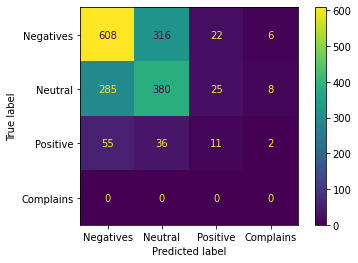

In [238]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [239]:
%%time

#predicting 
y_pred = dt_model.predict(X_test.values.astype('U'))

model_score = dt_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.5695553021664767
Model Score: 56.96%

Accuracy: 0.5695553021664767
Accuracy: 56.96%

F1-score: 0.5669147615479808
F1-score: 56.69%

CPU times and Wall time: 
CPU times: user 82.7 ms, sys: 904 µs, total: 83.6 ms
Wall time: 91.7 ms


In [240]:
# Save to file / directory
joblib_file = "models/DecisionTreeClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(dt_model, joblib_file)

['models/DecisionTreeClassifier_model_score_56.96.pkl']

# 4.4 KNEIGHBORS CLASSIFIER

In [241]:
# Initialize a vectorization and modelling pipeline
kn_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', KNeighborsClassifier()), 
 ])

In [259]:
# Algorithm training X_train, X_test, y_train, y_test
kn_model = kn_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
kn_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', KNeighborsClassifier())])

In [243]:
y_pred = kn_model.predict(X_test.values.astype('U'))
kn_model.classes_

array(['-1', '0', '1', 'complains'], dtype='<U9')

In [244]:
cm = confusion_matrix(y_test, y_pred, labels=kn_model.classes_)
print(cm)

[[654 285  13   0]
 [304 382  12   0]
 [ 48  48   8   0]
 [  0   0   0   0]]


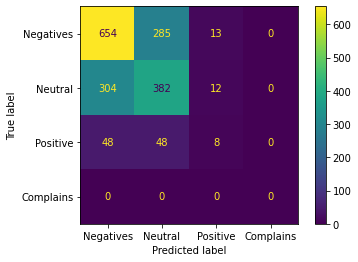

In [245]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [246]:
%%time

#predicting 
y_pred = kn_model.predict(X_test.values.astype('U'))

model_score = kn_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.5952109464082098
Model Score: 59.52%

Accuracy: 0.5952109464082098
Accuracy: 59.52%

F1-score: 0.5846712188863151
F1-score: 58.47%

CPU times and Wall time: 
CPU times: user 5.98 s, sys: 19.1 ms, total: 6 s
Wall time: 5.86 s


In [247]:
# Save to file / directory
joblib_file = "models/KNeighborsClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(kn_model, joblib_file)

['models/KNeighborsClassifier_model_score_59.52.pkl']

# 4.5 LOGISTIC REGRESSION 

In [248]:
# Initialize a vectorization and modelling pipeline
lr_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,5))),
     ('tfidf', TfidfTransformer()),
     ('clf', LogisticRegression()), 
 ])

In [249]:
# Algorithm training X_train, X_test, y_train, y_test
lr_model = lr_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
lr_model

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 5))),
                ('tfidf', TfidfTransformer()), ('clf', LogisticRegression())])

In [250]:
y_pred = lr_model.predict(X_test.values.astype('U'))
lr_model.classes_

array(['-1', '0', '1', 'complains'], dtype='<U9')

In [252]:
cm = confusion_matrix(y_test, y_pred, labels=lr_model.classes_)
print(cm)

[[772 180   0   0]
 [318 380   0   0]
 [ 63  41   0   0]
 [  0   0   0   0]]


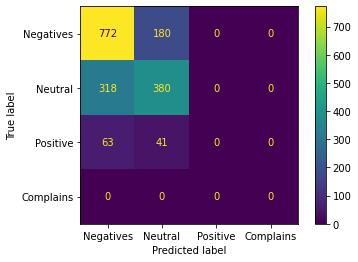

In [253]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [254]:
%%time

#predicting 
y_pred = lr_model.predict(X_test.values.astype('U'))

model_score = lr_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6567844925883695
Model Score: 65.68%

Accuracy: 0.6567844925883695
Accuracy: 65.68%

F1-score: 0.6309348683613238
F1-score: 63.09%

CPU times and Wall time: 
CPU times: user 324 ms, sys: 2.21 ms, total: 326 ms
Wall time: 781 ms


In [255]:
# Save to file / directory
joblib_file = "models/Logistic regression_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(kn_model, joblib_file)

['models/Logistic regression_model_score_65.68.pkl']

# 4.6 GRADIENT BOOSTING CLASSIFIER

In [256]:
# Initialize a vectorization and modelling pipeline
gd_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', GradientBoostingClassifier()), 
 ])

In [261]:
# Algorithm training X_train, X_test, y_train, y_test
gd_model = gd_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
gd_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', GradientBoostingClassifier())])

In [262]:
y_pred = gd_model.predict(X_test.values.astype('U'))
gd_model.classes_

array(['-1', '0', '1', 'complains'], dtype='<U9')

In [263]:
cm = confusion_matrix(y_test, y_pred, labels=gd_model.classes_)
print(cm)

[[754 186  12   0]
 [378 318   2   0]
 [ 65  36   3   0]
 [  0   0   0   0]]


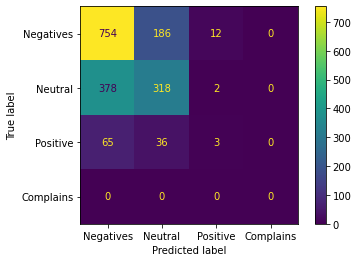

In [264]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [265]:
%%time

#predicting 
y_pred = gd_model.predict(X_test.values.astype('U'))

model_score = gd_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.612884834663626
Model Score: 61.29%

Accuracy: 0.612884834663626
Accuracy: 61.29%

F1-score: 0.5882445421651935
F1-score: 58.82%

CPU times and Wall time: 
CPU times: user 85.9 ms, sys: 0 ns, total: 85.9 ms
Wall time: 88.8 ms


In [266]:
# Save to file / directory
joblib_file = "models/GradientBoostingClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(gd_model, joblib_file)

['models/GradientBoostingClassifier_model_score_61.29.pkl']

# 4.7 MULTINOMIALNB

In [267]:
# Initialize a vectorization and modelling pipeline
mnb_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', MultinomialNB()), 
 ])

In [268]:
# Algorithm training X_train, X_test, y_train, y_test
mnb_model = mnb_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
mnb_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', MultinomialNB())])

In [269]:
y_pred = mnb_model.predict(X_test.values.astype('U'))
mnb_model.classes_

array(['-1', '0', '1', 'complains'], dtype='<U9')

In [270]:
cm = confusion_matrix(y_test, y_pred, labels=mnb_model.classes_)
print(cm)

[[840 112   0   0]
 [421 277   0   0]
 [ 79  25   0   0]
 [  0   0   0   0]]


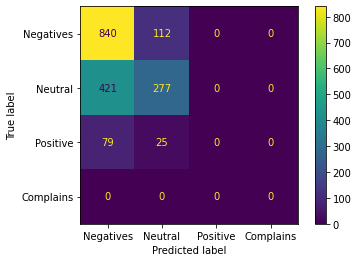

In [271]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [272]:
%%time

#predicting 
y_pred = mnb_model.predict(X_test.values.astype('U'))

model_score = mnb_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.636830102622577
Model Score: 63.68%

Accuracy: 0.636830102622577
Accuracy: 63.68%

F1-score: 0.5960921615946212
F1-score: 59.61%

CPU times and Wall time: 
CPU times: user 113 ms, sys: 1.85 ms, total: 115 ms
Wall time: 146 ms


In [273]:
# Save to file / directory
joblib_file = "models/MultinomialNB_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(mnb_model, joblib_file)

['models/MultinomialNB_model_score_63.68.pkl']

# 4.8 XGBoost classifier

In [158]:
xgb_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', xgb.XGBClassifier()), 
 ])

In [274]:
# Algorithm training X_train, X_test, y_train, y_test
xgb_model = xgb_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
xgb_model

AttributeError: ignored

In [275]:
y_pred = xgb_model.predict(X_test.values.astype('U'))
xgb_model.classes_

NameError: ignored

In [276]:
cm = confusion_matrix(y_test, y_pred, labels=xgb_model.classes_)
print(cm)

NameError: ignored

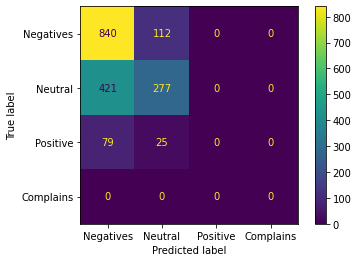

In [277]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [278]:
%%time

#predicting 
y_pred = xgb_model.predict(X_test.values.astype('U'))

model_score = xgb_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

NameError: ignored

In [279]:
# Save to file / directory
joblib_file = "models/XGBClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(xgb_model, joblib_file)

NameError: ignored

# 4.9 LightGBM classifier

In [280]:
lgbm_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', ltb.LGBMClassifier()), 
 ])

In [281]:
# Algorithm training X_train, X_test, y_train, y_test
lgbm_model = lgbm_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
lgbm_model

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf', LGBMClassifier())])

In [282]:
y_pred = lgbm_model.predict(X_test.values.astype('U'))
lgbm_model.classes_

array(['-1', '0', '1', 'complains'], dtype='<U9')

In [283]:
cm = confusion_matrix(y_test, y_pred, labels=lgbm_model.classes_)
print(cm)

[[688 262   2   0]
 [288 405   5   0]
 [ 54  44   6   0]
 [  0   0   0   0]]


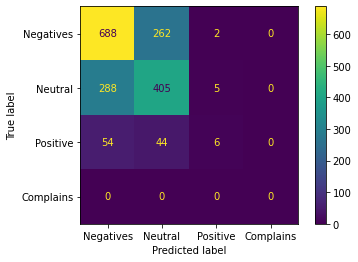

In [284]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [285]:
%%time

#predicting 
y_pred = lgbm_model.predict(X_test.values.astype('U'))

model_score = lgbm_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6265678449258837
Model Score: 62.66%

Accuracy: 0.6265678449258837
Accuracy: 62.66%

F1-score: 0.6116615124553274
F1-score: 61.17%

CPU times and Wall time: 
CPU times: user 264 ms, sys: 3.82 ms, total: 268 ms
Wall time: 180 ms


In [286]:
# Save to file / directory
joblib_file = "models/LGBMClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(lgbm_model, joblib_file)

['models/LGBMClassifier_model_score_62.66.pkl']

# 4.10 CatBoost classifier

In [287]:
ctb_pipeline = Pipeline([
     ('vect', CountVectorizer(ngram_range=(1,1))),
     ('tfidf', TfidfTransformer()),
     ('clf', ctb.CatBoostClassifier()), 
 ])

In [288]:
# Algorithm training X_train, X_test, y_train, y_test
ctb_model = ctb_pipeline.fit(X_train.values.astype('U'), y_train.values.astype('U'))
ctb_model

Learning rate set to 0.087391
0:	learn: 1.3202930	total: 227ms	remaining: 3m 47s
1:	learn: 1.2635430	total: 422ms	remaining: 3m 30s
2:	learn: 1.2169659	total: 607ms	remaining: 3m 21s
3:	learn: 1.1756006	total: 798ms	remaining: 3m 18s
4:	learn: 1.1411126	total: 985ms	remaining: 3m 16s
5:	learn: 1.1101760	total: 1.18s	remaining: 3m 15s
6:	learn: 1.0826509	total: 1.39s	remaining: 3m 17s
7:	learn: 1.0592793	total: 1.58s	remaining: 3m 15s
8:	learn: 1.0383895	total: 1.79s	remaining: 3m 17s
9:	learn: 1.0198276	total: 2.05s	remaining: 3m 22s
10:	learn: 1.0032939	total: 2.31s	remaining: 3m 27s
11:	learn: 0.9879555	total: 2.66s	remaining: 3m 39s
12:	learn: 0.9750720	total: 3.01s	remaining: 3m 48s
13:	learn: 0.9636331	total: 3.35s	remaining: 3m 55s
14:	learn: 0.9525410	total: 3.69s	remaining: 4m 2s
15:	learn: 0.9426020	total: 4.09s	remaining: 4m 11s
16:	learn: 0.9336400	total: 4.46s	remaining: 4m 17s
17:	learn: 0.9251504	total: 4.99s	remaining: 4m 32s
18:	learn: 0.9177164	total: 5.33s	remaining: 

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf',
                 <catboost.core.CatBoostClassifier object at 0x7fb925380040>)])

In [293]:
y_pred = ctb_model.predict(X_test.values.astype('U'))
ctb_model.classes_

array(['-1', '0', '1', 'complains'], dtype=object)

In [294]:
cm = confusion_matrix(y_test, y_pred, labels=ctb_model.classes_)
print(cm)

[[726 224   2   0]
 [314 382   2   0]
 [ 56  45   3   0]
 [  0   0   0   0]]


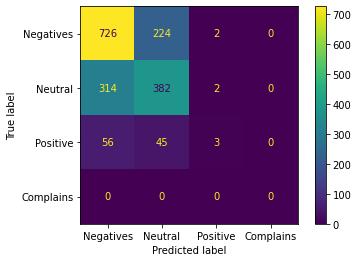

In [295]:
cm_dsp=ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negatives', 'Neutral', 'Positive', 'Complains'])
cm_dsp.plot()

In [296]:
%%time

#predicting 
y_pred = ctb_model.predict(X_test.values.astype('U'))

model_score = ctb_model.score(X_test.values.astype('U'), y_test.values.astype('U'))
print(f'Model Score: {model_score}')
print(f'Model Score: {model_score*100:.2f}%')
accuracy = accuracy_score(y_test, y_pred)
print()
print(f"Accuracy: {accuracy}")
print(f"Accuracy: {accuracy*100:.2f}%")
print()
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"F1-score: {f1}")
print(f"F1-score: {f1*100:.2f}%")
print()
print("CPU times and Wall time: ")

Model Score: 0.6334093500570125
Model Score: 63.34%

Accuracy: 0.6334093500570125
Accuracy: 63.34%

F1-score: 0.6133887482820449
F1-score: 61.34%

CPU times and Wall time: 
CPU times: user 214 ms, sys: 5.12 ms, total: 219 ms
Wall time: 166 ms


In [167]:
# Save to file / directory
joblib_file = "models/CatBoostClassifier_model_score_"+ str(round(accuracy*100,2))+".pkl"
joblib.dump(ctb_model, joblib_file)

['models/CatBoostClassifier_model_score_63.34.pkl']